**Importation des librairies**

In [1]:
import numpy as np 
from scipy import sparse 
from tqdm import tqdm
import random 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import time 

**UTILS**

In [2]:
def time_it(function):
    def wrapper(*args,**kwargs):
        begin = time.time()
        result = function(*args,**kwargs)
        end = time.time()
        print("\n"+function.__name__ + " a mis : {} s".format(end-begin))
        return result
    return wrapper

In [3]:
def accuracy(x,a,b):
    product = a.dot(x)
    predict = np.sign(product)
    correct = np.sum(b == predict)
    accuracy =  correct / len(b)
    return accuracy

**Chargement et preprocess du Dataset**

In [4]:
mnist_train = pd.read_csv("mnist_train.csv",header=None)
mnist_test = pd.read_csv("mnist_test.csv",header=None)

y_train = mnist_train.loc[:,0].to_numpy()
y_test = mnist_test.loc[:,0].to_numpy()
X_train = mnist_train.loc[:,1:].to_numpy()
X_test = mnist_test.loc[:,1:].to_numpy()

# normalisation
X_train = X_train/255.
X_test = X_test/255.
# 0 vs others
y_train = (y_train == 0)
y_test = (y_test == 0)
# Vector preparation : on rajoute une ligne de 1 pour ne pas avoir a expliciter le biais
X_train = np.concatenate([X_train, np.ones((len(X_train), 1))], axis=1)
X_test = np.concatenate([X_test, np.ones((len(X_test), 1))], axis=1)

**Loss, gradient et Hessienne logisitique**

In [5]:
sigmoid = lambda z : 1/(1 + np.exp(-z))

def logistic(x,a,b,s=None,test=False):
    n,d = a.shape
    sigma = sigmoid(np.dot(a,x))
    loss = - (b * np.log(sigma) + (1-b)*np.log(1-sigma)).mean()
    grad = None
    hess_product = None
    if(test==False):
        grad = (sigma-b)@a
    if(s is not None):
        hess_product = sigma @ (1-sigma) * np.dot(a,s) @ a
    return loss, grad, hess_product

**Algorithme SGD**

In [57]:
@time_it
def SGD(a, b, a_test, b_test, T, alpha, batch_size): 
    np.random.seed(42)
    n, d = a.shape
    
    x = np.zeros(d)
    x_avg = np.zeros(d)
    loss_test = np.zeros(T)
    errors_test = np.zeros(T)
    for t in tqdm(range(1, T + 1)):
        # pick random samples
        I = np.random.randint(0, n, batch_size)
        eta_t = alpha / t
        grad_sum = np.zeros(d)
        for i in I:
            a_, b_ = a[i][np.newaxis, :], np.array([b[i]])
            l_train, grad, _ = logistic(x,a_,b_)
            grad_sum += grad
            
        l_test, _, _, = logistic(x_avg,a_test,b_test, test=True)
        loss_test[t-1] = l_test
        errors_test[t-1] = 1 - accuracy(x_avg, a_test,b_test)
        x -= eta_t * grad_sum / BATCH_SIZE
        
        # averaging
        x_avg = (x_avg * (t - 1) + x) / t
        
    return x_avg, loss_test, errors_test

**Algorithme SQN**

In [8]:
def LBFGS(s_all,y_all,M,t,grad,d):
    m_ = min(t,M)
    q = grad
    H_0 = s_all[m_ - 1,:].dot(y_all[m_-1,:].T)/y_all[m_ - 1,:].dot(y_all[m_-1,:].T)
    saved_a = np.zeros([M,1])
    
    for j in range(t-1, t-m_ -1, -1):
        rho = 1/(s_all[j-t +m_,:].dot(y_all[j-t+m_,:].T))
        alpha = (rho*(s_all[j-t+m_,:].dot(q.T)))
        saved_a[j-(t-m_)] = alpha
        q -= alpha * (y_all[j-t+m_,:])
        
    z = H_0*q.T
    
    for j in range(t-m_, t):
        rho = 1/(s_all[j-t+m_,:].dot(y_all[j-t+m_,:].T))
        beta = rho*(y_all[j-t+m_,:].dot(z))
        temp = s_all[j-t+m_,:].T*((saved_a[j-(t-m_)] - beta))
        z +=  temp.T
    return z.T

In [59]:
@time_it
def SQN(a, b, a_test, b_test, T, alpha, batch_size, batch_size_H):
    np.random.seed(42)
    n, d = a.shape
    L = 20                            
    M = 5                          
    t = -1   
    w_hat = np.zeros(d)                       
    w_hat_new = w_hat                            
    s_ = np.zeros([M,d])                
    y_ = np.zeros([M,d])    
    x = np.zeros(d)
    x_avg = np.zeros(d)
    
    loss_test = np.zeros(T)
    errors_test = np.zeros(T)
    
    for k in tqdm(range(1,T+1)):
        I = np.random.randint(0, n, batch_size)
        eta_t = alpha / k
        grad_sum = np.zeros(d)
        for i in I: 
            a_, b_ = a[i][np.newaxis, :], np.array([b[i]])
            _, grad, _ = logistic(x, a_, b_)
            grad_sum += grad
            
        l_test, _, _, = logistic(x_avg,a_test,b_test, test=True)
            
        loss_test[k-1] = l_test
        errors_test[k-1] = 1 - accuracy(x_avg, a_test,b_test)
        
        w_hat_new += x    
        if k <= 2*L:
            x -= eta_t*grad_sum/batch_size
        else:
            H_grad = LBFGS(s_,y_,M,t,grad_sum/batch_size,d)
            x -= eta_t*H_grad
            
        if k%L == 0:
            t = t + 1
            w_hat_new /= L
            if t > 0:
                I_H = np.random.randint(0, n, batch_size_H)
                Hsum = np.zeros(d)
                s = w_hat_new - w_hat
                for i in I_H:
                    a_H, b_H = a[i][np.newaxis, :], np.array([b[i]])
                    _, _, Hs = logistic(w_hat_new , a_H, b_H, s=s)
                    Hsum += Hs
                y = Hsum / batch_size_H
                if t == 1:
                    s_[0,:] = s
                    y_[0,:] = y
                elif (t > 1) and (t <= M):
                    s_[t-1,:] = s
                    y_[t-1,:] = y
                else:
                    s_[range(0,M-1),:] = s_[range(1,M),:]
                    s_[M-1,:] = s
                    y_[range(0,M-1),:] = y_[range(1,M),:]
                    y_[M-1,:] = y
            w_hat = w_hat_new
            w_hat_new = np.zeros(d)
        x_avg = (x_avg * (k - 1) + x) / k
    return x_avg, loss_test, errors_test

In [60]:
batch_sizes = [50,300,1000]
learning_rates = [1,5,10]
SGDvsSQN_batch_lr = {}

In [61]:
for b in batch_sizes:
    for lr in learning_rates: 
        
        _, loss_sgd, _ = SGD(X_train,y_train,X_test,y_test,10000,lr,b)
        _, loss_sqn, _ = SQN(X_train,y_train,X_test,y_test,10000,lr,b,1000)
        
        SGDvsSQN_batch_lr[f'SGD : b = {b}, beta = {lr}'] = loss_sgd
        SGDvsSQN_batch_lr[f'SQN : b = {b}, beta = {lr}'] = loss_sqn

100%|██████████| 10000/10000 [02:06<00:00, 78.82it/s]



SGD a mis : 126.87679481506348 s


100%|██████████| 10000/10000 [02:35<00:00, 64.44it/s]



SQN a mis : 155.19086480140686 s


100%|██████████| 10000/10000 [02:00<00:00, 82.66it/s]



SGD a mis : 120.97479629516602 s


100%|██████████| 10000/10000 [02:33<00:00, 65.16it/s]



SQN a mis : 153.47784948349 s


100%|██████████| 10000/10000 [01:59<00:00, 83.69it/s]



SGD a mis : 119.49690008163452 s


  0%|          | 18/10000 [00:00<01:54, 87.09it/s]C:\Users\REINST~1\AppData\Local\Temp/ipykernel_15044/318110876.py:6: RuntimeWarning: divide by zero encountered in log
  loss = - (b * np.log(sigma) + (1-b)*np.log(1-sigma)).mean()
C:\Users\REINST~1\AppData\Local\Temp/ipykernel_15044/318110876.py:6: RuntimeWarning: invalid value encountered in multiply
  loss = - (b * np.log(sigma) + (1-b)*np.log(1-sigma)).mean()
100%|██████████| 10000/10000 [02:39<00:00, 62.70it/s]



SQN a mis : 159.49086117744446 s


100%|██████████| 10000/10000 [04:14<00:00, 39.36it/s]



SGD a mis : 254.0636329650879 s


100%|██████████| 10000/10000 [04:47<00:00, 34.72it/s]



SQN a mis : 287.9886600971222 s


100%|██████████| 10000/10000 [04:13<00:00, 39.45it/s]



SGD a mis : 253.4760127067566 s


100%|██████████| 10000/10000 [04:42<00:00, 35.36it/s]



SQN a mis : 282.78426146507263 s


100%|██████████| 10000/10000 [04:05<00:00, 40.68it/s]



SGD a mis : 245.84518575668335 s


100%|██████████| 10000/10000 [04:40<00:00, 35.66it/s]



SQN a mis : 280.45965051651 s


  1%|▏         | 137/10000 [00:08<09:55, 16.57it/s]


KeyboardInterrupt: 

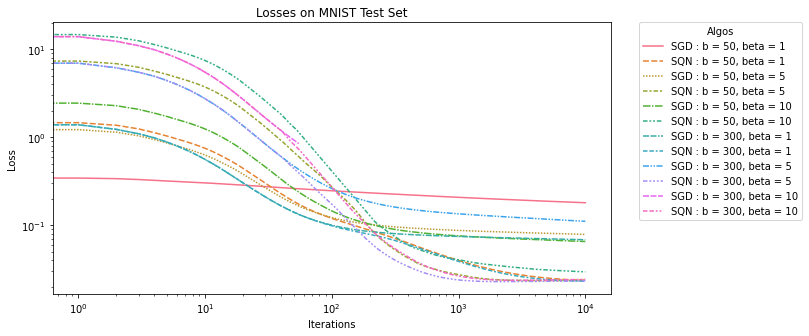

In [65]:
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=list(SGDvsSQN_batch_lr.values()), linewidth=1.5,legend=False)
ax.set(xlabel='Iterations', 
       ylabel='Loss', 
       title='Losses on MNIST Test Set', 
       xticks=[1, 10, 100, 1000, 10000],
       yticks=[0.01,0.02,0.05,0.1,0.2,0.5,1.],
       )
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(title='Algos', title_fontsize = 13,loc = 'best',
          labels=list(SGDvsSQN_batch_lr.keys()))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
           title='Algos',
          labels=list(SGDvsSQN_batch_lr.keys()))
plt.show()

In [71]:
batch_sizes_H = [100,500,1000,3000]
SQN_batch_H = {}

In [72]:
for b_H in batch_sizes_H:
    _, loss_sqn, _ = SQN(X_train,y_train,X_test,y_test,1000,5,300,b_H)

    SQN_batch_H[f'b_H = {b_H}'] = loss_sqn

100%|██████████| 1000/1000 [00:24<00:00, 40.12it/s]



SQN a mis : 24.92864179611206 s


100%|██████████| 1000/1000 [00:26<00:00, 38.40it/s]



SQN a mis : 26.040342569351196 s


100%|██████████| 1000/1000 [00:28<00:00, 35.60it/s]



SQN a mis : 28.088948488235474 s


100%|██████████| 1000/1000 [00:34<00:00, 28.91it/s]


SQN a mis : 34.59323740005493 s


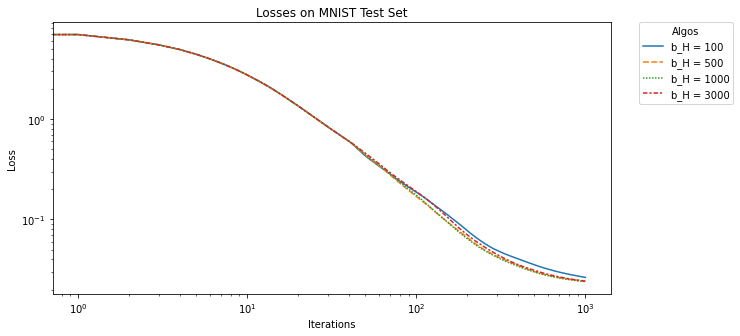

In [74]:
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=list(SQN_batch_H.values()), linewidth=1.5,legend=False)
ax.set(xlabel='Iterations', 
       ylabel='Loss', 
       title='Losses on MNIST Test Set', 
       xticks=[1, 10, 100, 1000, 10000],
       yticks=[0.01,0.02,0.05,0.1,0.2,0.5,1.],
       )
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(title='Algos', title_fontsize = 13,loc = 'best',
          labels=list(SQN_batch_H.keys()))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
           title='Algos',
          labels=list(SQN_batch_H.keys()))
plt.show()